In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import minmax_scale
import copy
import seaborn as sns
import heapq
import scipy.stats as stats
from dtw import *
import dtw
from scipy.signal import hilbert, butter, filtfilt
from scipy.fftpack import fft,fftfreq,rfft,irfft,ifft
import seaborn as sns
import scipy.stats as stats
from IPython.display import Image, display

In [ ]:
df_2022 = pd.read_csv('2022_sub_region_1_daily_2022_US_Georgia_daily_symptoms_dataset.csv')
df_2021 = pd.read_csv('2021_sub_region_1_daily_2021_US_Georgia_daily_symptoms_dataset.csv')
df_2020 = pd.read_csv('2020_sub_region_1_daily_2020_US_Georgia_daily_symptoms_dataset.csv')
df = pd.concat([df_2020, df_2021, df_2022], ignore_index=True)
df

,country_region_code,country_region,sub_region_1,sub_region_1_code,sub_region_2,sub_region_2_code,place_id,date,symptom:Abdominal obesity,symptom:Abdominal pain,...,symptom:Wart,symptom:Water retention,symptom:Weakness,symptom:Weight gain,symptom:Wheeze,symptom:Xeroderma,symptom:Xerostomia,symptom:Yawn,symptom:hyperhidrosis,symptom:pancreatitis
0,US,United States,Georgia,US-GA,NaN,NaN,ChIJV4FfHcU28YgR5xBP7BC8hGY,2020-01-01,2.65,4.76,...,1.23,0.23,0.34,3.33,0.33,2.67,0.39,0.18,0.39,0.37
1,US,United States,Georgia,US-GA,NaN,NaN,ChIJV4FfHcU28YgR5xBP7BC8hGY,2020-01-02,2.67,4.77,...,1.29,0.24,0.36,3.50,0.33,2.68,0.42,0.16,0.42,0.39
2,US,United States,Georgia,US-GA,NaN,NaN,ChIJV4FfHcU28YgR5xBP7BC8hGY,2020-01-03,2.44,4.68,...,1.26,0.23,0.37,3.41,0.28,2.45,0.39,0.18,0.46,0.46
3,US,United States,Georgia,US-GA,NaN,NaN,ChIJV4FfHcU28YgR5xBP7BC8hGY,2020-01-04,2.63,4.67,...,1.23,0.24,0.33,3.27,0.28,2.77,0.37,0.21,0.51,0.37
4,US,United States,Georgia,US-GA,NaN,NaN,ChIJV4FfHcU28YgR5xBP7BC8hGY,2020-01-05,2.78,4.66,...,1.18,0.24,0.36,3.62,0.30,2.89,0.38,0.17,0.47,0.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144217,US,United States,Georgia,US-GA,Worth County,13321.0,ChIJx3zQ2XoM8ogRVKVnnEtOAac,2022-09-23,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
144218,US,United States,Georgia,US-GA,Worth County,13321.0,ChIJx3zQ2XoM8ogRVKVnnEtOAac,2022-09-24,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
144219,US,United States,Georgia,US-GA,Worth County,13321.0,ChIJx3zQ2XoM8ogRVKVnnEtOAac,2022-09-25,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
144220,US,United States,Georgia,US-GA,Worth County,13321.0,ChIJx3zQ2XoM8ogRVKVnnEtOAac,2022-09-26,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
meta_column = ["country_region_code","country_region","sub_region_1","sub_region_1_code","sub_region_2","sub_region_2_code","place_id","date"]
df['date'] = pd.to_datetime(df['date'])
df = df.resample('1W', on='date').mean().reset_index()
df

,date,sub_region_2_code,symptom:Abdominal obesity,symptom:Abdominal pain,symptom:Acne,symptom:Actinic keratosis,symptom:Acute bronchitis,symptom:Adrenal crisis,symptom:Ageusia,symptom:Alcoholism,...,symptom:Wart,symptom:Water retention,symptom:Weakness,symptom:Weight gain,symptom:Wheeze,symptom:Xeroderma,symptom:Xerostomia,symptom:Yawn,symptom:hyperhidrosis,symptom:pancreatitis
0,2020-01-05,13157.711048,2.711852,5.431232,9.262482,0.272941,0.792750,0.103000,0.078333,4.496473,...,1.277483,0.258214,0.352632,3.541811,0.276429,2.655135,0.436154,0.162800,0.497451,0.398974
1,2020-01-12,13158.013013,2.642950,4.915736,8.447479,0.302653,0.691429,0.101600,0.056000,3.924156,...,1.348348,0.257381,0.414375,3.525100,0.240513,2.454217,0.444459,0.170606,0.543626,0.344528
2,2020-01-19,13158.328000,2.613067,4.962869,8.052379,0.294118,0.582364,0.104615,0.059000,3.930026,...,1.358080,0.289783,0.432879,3.464493,0.263333,2.168368,0.434928,0.177647,0.580795,0.336000
3,2020-01-26,13158.585657,2.544214,4.937223,8.656388,0.309423,0.548704,0.104167,0.048750,3.910237,...,1.309156,0.255122,0.419836,3.435556,0.236585,2.883028,0.480139,0.157714,0.481310,0.322075
4,2020-02-02,13158.362637,2.419357,4.886295,7.779816,0.317358,0.594286,0.102593,0.062000,3.997003,...,1.298783,0.257955,0.421045,3.350767,0.262143,2.475161,0.456970,0.174286,0.510795,0.339412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,2022-09-04,13158.441675,1.945748,4.989816,6.658024,0.335932,0.396364,0.100800,0.076250,3.660051,...,1.291121,0.283913,0.410000,3.031930,0.256500,2.038586,0.464805,0.158286,0.586559,0.311273
140,2022-09-11,13158.246521,1.973788,5.030644,6.847928,0.339138,0.430909,0.095926,0.073846,3.713443,...,1.272554,0.278667,0.403030,2.963983,0.250682,2.017031,0.426933,0.161143,0.552447,0.350714
141,2022-09-18,13158.196819,1.934751,4.953216,6.581513,0.356508,0.405660,0.091429,0.060000,3.694783,...,1.305304,0.264889,0.427027,3.040880,0.269535,2.071126,0.435128,0.162647,0.524783,0.337455
142,2022-09-25,13158.573280,1.907674,4.830499,6.543102,0.321250,0.438889,0.088500,0.064545,3.670749,...,1.300690,0.284255,0.412000,2.929078,0.271628,2.024074,0.440390,0.150286,0.532791,0.332037


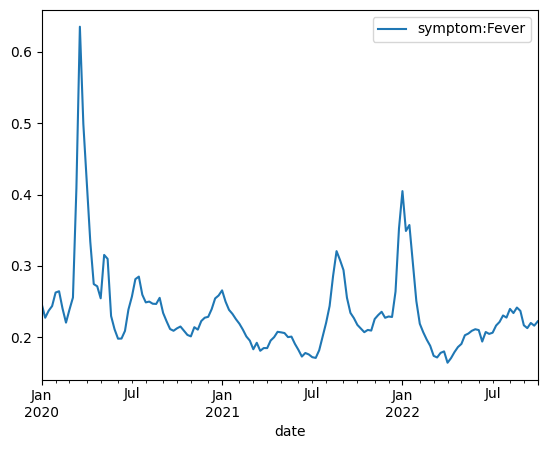

In [ ]:
df.iloc[:,len(meta_column):] = (df.iloc[:,len(meta_column):].div(df.iloc[:,len(meta_column):].sum(axis=1), axis=0)*100).div(df.iloc[:,len(meta_column):].median(axis=0), axis=1)
df.plot(x = 'date', y = 'symptom:Fever')
plt.show()

In [ ]:
covid_data = pd.read_csv('Weekly_United_States_COVID-19_Cases_and_Deaths_by_State.csv')

In [ ]:
for n, week in copy.copy(covid_data.groupby('date_updated')):
    week = week.reset_index(drop=True)
    tempdf = pd.DataFrame([[week.date_updated.loc[0], 'National', week.start_date.loc[0], week.end_date.loc[0], week.tot_cases.sum(), week.new_cases.sum(), week.tot_deaths.sum(), week.new_deaths.sum()]], columns = covid_data.columns)
    covid_data = pd.concat([covid_data, tempdf], ignore_index= True)

In [ ]:
covid_data = covid_data.loc[covid_data.state == 'National']

In [ ]:
covid_data = covid_data.loc[(covid_data.date_updated >= '2020-01-26') & (covid_data.date_updated <= '2022-10-02')].reset_index(drop=True)
df = df.loc[(df.date >= '2020-01-23') & (df.date <= '2022-09-29')].reset_index(drop=True)

In [ ]:
covid_data

,date_updated,state,start_date,end_date,tot_cases,new_cases,tot_deaths,new_deaths
0,2020-01-30,National,2020-01-23,2020-01-29,16,7,0,0
1,2020-02-06,National,2020-01-30,2020-02-05,26,10,0,0
2,2020-02-13,National,2020-02-06,2020-02-12,36,10,0,0
3,2020-02-20,National,2020-02-13,2020-02-19,52,16,0,0
4,2020-02-27,National,2020-02-20,2020-02-26,83,31,0,0
...,...,...,...,...,...,...,...,...
135,2022-09-01,National,2022-08-25,2022-08-31,94484362,616605,1042221,3954
136,2022-09-08,National,2022-09-01,2022-09-07,95009982,525620,1045189,2968
137,2022-09-15,National,2022-09-08,2022-09-14,95481547,471565,1048400,3211
138,2022-09-22,National,2022-09-15,2022-09-21,95876590,395043,1051537,3137


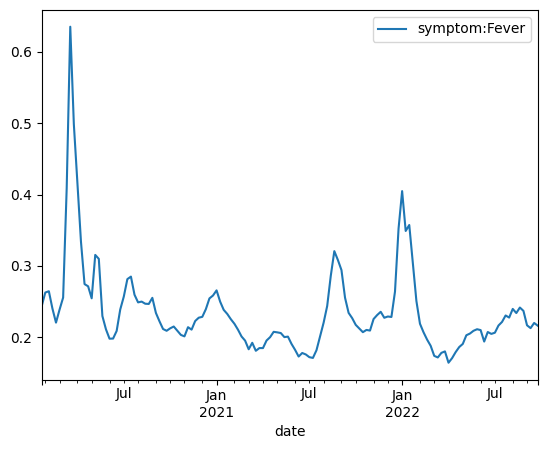

In [ ]:
df.plot(x = 'date', y = 'symptom:Fever')
plt.show()

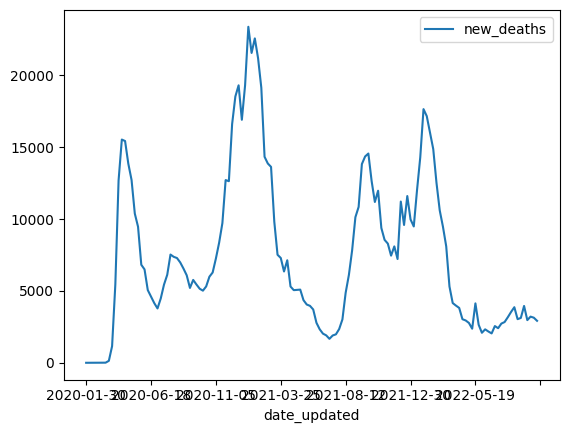

In [ ]:
covid_data.plot(x = 'date_updated', y = 'new_deaths')
plt.show()

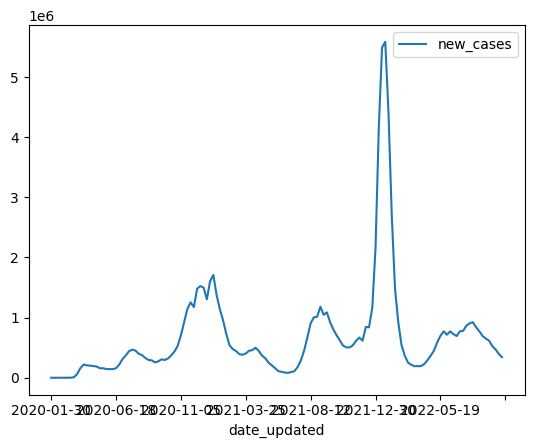

In [ ]:
covid_data.plot(x = 'date_updated', y = 'new_cases')
plt.show()

### Global PCC

In [ ]:
symptoms = ["symptom:Abdominal obesity","symptom:Abdominal pain","symptom:Acne","symptom:Actinic keratosis","symptom:Acute bronchitis","symptom:Adrenal crisis","symptom:Ageusia","symptom:Alcoholism","symptom:Allergic conjunctivitis","symptom:Allergy","symptom:Amblyopia","symptom:Amenorrhea","symptom:Amnesia","symptom:Anal fissure","symptom:Anaphylaxis","symptom:Anemia","symptom:Angina pectoris","symptom:Angioedema","symptom:Angular cheilitis","symptom:Anosmia","symptom:Anxiety","symptom:Aphasia","symptom:Aphonia","symptom:Apnea","symptom:Arthralgia","symptom:Arthritis","symptom:Ascites","symptom:Asperger syndrome","symptom:Asphyxia","symptom:Asthma","symptom:Astigmatism","symptom:Ataxia","symptom:Atheroma","symptom:Attention deficit hyperactivity disorder","symptom:Auditory hallucination","symptom:Autoimmune disease","symptom:Avoidant personality disorder","symptom:Back pain","symptom:Bacterial vaginosis","symptom:Balance disorder","symptom:Beau's lines","symptom:Bell's palsy","symptom:Biliary colic","symptom:Binge eating","symptom:Bleeding","symptom:Bleeding on probing","symptom:Blepharospasm","symptom:Bloating","symptom:Blood in stool","symptom:Blurred vision","symptom:Blushing","symptom:Boil","symptom:Bone fracture","symptom:Bone tumor","symptom:Bowel obstruction","symptom:Bradycardia","symptom:Braxton Hicks contractions","symptom:Breakthrough bleeding","symptom:Breast pain","symptom:Bronchitis","symptom:Bruise","symptom:Bruxism","symptom:Bunion","symptom:Burn","symptom:Burning Chest Pain","symptom:Burning mouth syndrome","symptom:Candidiasis","symptom:Canker sore","symptom:Cardiac arrest","symptom:Carpal tunnel syndrome","symptom:Cataplexy","symptom:Cataract","symptom:Chancre","symptom:Cheilitis","symptom:Chest pain","symptom:Chills","symptom:Chorea","symptom:Chronic pain","symptom:Cirrhosis","symptom:Cleft lip and cleft palate","symptom:Clouding of consciousness","symptom:Cluster headache","symptom:Colitis","symptom:Coma","symptom:Common cold","symptom:Compulsive behavior","symptom:Compulsive hoarding","symptom:Confusion","symptom:Congenital heart defect","symptom:Conjunctivitis","symptom:Constipation","symptom:Convulsion","symptom:Cough","symptom:Crackles","symptom:Cramp","symptom:Crepitus","symptom:Croup","symptom:Cyanosis","symptom:Dandruff","symptom:Delayed onset muscle soreness","symptom:Dementia","symptom:Dentin hypersensitivity","symptom:Depersonalization","symptom:Depression","symptom:Dermatitis","symptom:Desquamation","symptom:Developmental disability","symptom:Diabetes","symptom:Diabetic ketoacidosis","symptom:Diarrhea","symptom:Dizziness","symptom:Dry eye syndrome","symptom:Dysautonomia","symptom:Dysgeusia","symptom:Dysmenorrhea","symptom:Dyspareunia","symptom:Dysphagia","symptom:Dysphoria","symptom:Dystonia","symptom:Dysuria","symptom:Ear pain","symptom:Eczema","symptom:Edema","symptom:Encephalitis","symptom:Encephalopathy","symptom:Epidermoid cyst","symptom:Epilepsy","symptom:Epiphora","symptom:Erectile dysfunction","symptom:Erythema","symptom:Erythema chronicum migrans","symptom:Esophagitis","symptom:Excessive daytime sleepiness","symptom:Eye pain","symptom:Eye strain","symptom:Facial nerve paralysis","symptom:Facial swelling","symptom:Fasciculation","symptom:Fatigue","symptom:Fatty liver disease","symptom:Fecal incontinence","symptom:Fever","symptom:Fibrillation","symptom:Fibrocystic breast changes","symptom:Fibromyalgia","symptom:Flatulence","symptom:Floater","symptom:Focal seizure","symptom:Folate deficiency","symptom:Food craving","symptom:Food intolerance","symptom:Frequent urination","symptom:Gastroesophageal reflux disease","symptom:Gastroparesis","symptom:Generalized anxiety disorder","symptom:Generalized tonic–clonic seizure","symptom:Genital wart","symptom:Gingival recession","symptom:Gingivitis","symptom:Globus pharyngis","symptom:Goitre","symptom:Gout","symptom:Grandiosity","symptom:Granuloma","symptom:Guilt","symptom:Hair loss","symptom:Halitosis","symptom:Hay fever","symptom:Headache","symptom:Heart arrhythmia","symptom:Heart murmur","symptom:Heartburn","symptom:Hematochezia","symptom:Hematoma","symptom:Hematuria","symptom:Hemolysis","symptom:Hemoptysis","symptom:Hemorrhoids","symptom:Hepatic encephalopathy","symptom:Hepatitis","symptom:Hepatotoxicity","symptom:Hiccup","symptom:Hip pain","symptom:Hives","symptom:Hot flash","symptom:Hydrocephalus","symptom:Hypercalcaemia","symptom:Hypercapnia","symptom:Hypercholesterolemia","symptom:Hyperemesis gravidarum","symptom:Hyperglycemia","symptom:Hyperkalemia","symptom:Hyperlipidemia","symptom:Hypermobility","symptom:Hyperpigmentation","symptom:Hypersomnia","symptom:Hypertension","symptom:Hyperthermia","symptom:Hyperthyroidism","symptom:Hypertriglyceridemia","symptom:Hypertrophy","symptom:Hyperventilation","symptom:Hypocalcaemia","symptom:Hypochondriasis","symptom:Hypoglycemia","symptom:Hypogonadism","symptom:Hypokalemia","symptom:Hypomania","symptom:Hyponatremia","symptom:Hypotension","symptom:Hypothyroidism","symptom:Hypoxemia","symptom:Hypoxia","symptom:Impetigo","symptom:Implantation bleeding","symptom:Impulsivity","symptom:Indigestion","symptom:Infection","symptom:Inflammation","symptom:Inflammatory bowel disease","symptom:Ingrown hair","symptom:Insomnia","symptom:Insulin resistance","symptom:Intermenstrual bleeding","symptom:Intracranial pressure","symptom:Iron deficiency","symptom:Irregular menstruation","symptom:Itch","symptom:Jaundice","symptom:Kidney failure","symptom:Kidney stone","symptom:Knee Pain","symptom:Kyphosis","symptom:Lactose intolerance","symptom:Laryngitis","symptom:Leg cramps","symptom:Lesion","symptom:Leukorrhea","symptom:Lightheadedness","symptom:Low back pain","symptom:Low-grade fever","symptom:Lymphedema","symptom:Major depressive disorder","symptom:Malabsorption","symptom:Male infertility","symptom:Manic Disorder","symptom:Melasma","symptom:Melena","symptom:Meningitis","symptom:Menorrhagia","symptom:Middle back pain","symptom:Migraine","symptom:Milium","symptom:Mitral insufficiency","symptom:Mood disorder","symptom:Mood swing","symptom:Morning sickness","symptom:Motion sickness","symptom:Mouth ulcer","symptom:Muscle atrophy","symptom:Muscle weakness","symptom:Myalgia","symptom:Mydriasis","symptom:Myocardial infarction","symptom:Myoclonus","symptom:Nasal congestion","symptom:Nasal polyp","symptom:Nausea","symptom:Neck mass","symptom:Neck pain","symptom:Neonatal jaundice","symptom:Nerve injury","symptom:Neuralgia","symptom:Neutropenia","symptom:Night sweats","symptom:Night terror","symptom:Nocturnal enuresis","symptom:Nodule","symptom:Nosebleed","symptom:Nystagmus","symptom:Obesity","symptom:Onychorrhexis","symptom:Oral candidiasis","symptom:Orthostatic hypotension","symptom:Osteopenia","symptom:Osteophyte","symptom:Osteoporosis","symptom:Otitis","symptom:Otitis externa","symptom:Otitis media","symptom:Pain","symptom:Palpitations","symptom:Panic attack","symptom:Papule","symptom:Paranoia","symptom:Paresthesia","symptom:Pelvic inflammatory disease","symptom:Pericarditis","symptom:Periodontal disease","symptom:Periorbital puffiness","symptom:Peripheral neuropathy","symptom:Perspiration","symptom:Petechia","symptom:Phlegm","symptom:Photodermatitis","symptom:Photophobia","symptom:Photopsia","symptom:Pleural effusion","symptom:Pleurisy","symptom:Pneumonia","symptom:Podalgia","symptom:Polycythemia","symptom:Polydipsia","symptom:Polyneuropathy","symptom:Polyuria","symptom:Poor posture","symptom:Post-nasal drip","symptom:Postural orthostatic tachycardia syndrome","symptom:Prediabetes","symptom:Proteinuria","symptom:Pruritus ani","symptom:Psychosis","symptom:Ptosis","symptom:Pulmonary edema","symptom:Pulmonary hypertension","symptom:Purpura","symptom:Pus","symptom:Pyelonephritis","symptom:Radiculopathy","symptom:Rectal pain","symptom:Rectal prolapse","symptom:Red eye","symptom:Renal colic","symptom:Restless legs syndrome","symptom:Rheum","symptom:Rhinitis","symptom:Rhinorrhea","symptom:Rosacea","symptom:Round ligament pain","symptom:Rumination","symptom:Scar","symptom:Sciatica","symptom:Scoliosis","symptom:Seborrheic dermatitis","symptom:Self-harm","symptom:Sensitivity to sound","symptom:Sexual dysfunction","symptom:Shallow breathing","symptom:Sharp pain","symptom:Shivering","symptom:Shortness of breath","symptom:Shyness","symptom:Sinusitis","symptom:Skin condition","symptom:Skin rash","symptom:Skin tag","symptom:Skin ulcer","symptom:Sleep apnea","symptom:Sleep deprivation","symptom:Sleep disorder","symptom:Snoring","symptom:Sore throat","symptom:Spasticity","symptom:Splenomegaly","symptom:Sputum","symptom:Stomach rumble","symptom:Strabismus","symptom:Stretch marks","symptom:Stridor","symptom:Stroke","symptom:Stuttering","symptom:Subdural hematoma","symptom:Suicidal ideation","symptom:Swelling","symptom:Swollen feet","symptom:Swollen lymph nodes","symptom:Syncope","symptom:Tachycardia","symptom:Tachypnea","symptom:Telangiectasia","symptom:Tenderness","symptom:Testicular pain","symptom:Throat irritation","symptom:Thrombocytopenia","symptom:Thyroid nodule","symptom:Tic","symptom:Tinnitus","symptom:Tonsillitis","symptom:Toothache","symptom:Tremor","symptom:Trichoptilosis","symptom:Tumor","symptom:Type 2 diabetes","symptom:Unconsciousness","symptom:Underweight","symptom:Upper respiratory tract infection","symptom:Urethritis","symptom:Urinary incontinence","symptom:Urinary tract infection","symptom:Urinary urgency","symptom:Uterine contraction","symptom:Vaginal bleeding","symptom:Vaginal discharge","symptom:Vaginitis","symptom:Varicose veins","symptom:Vasculitis","symptom:Ventricular fibrillation","symptom:Ventricular tachycardia","symptom:Vertigo","symptom:Viral pneumonia","symptom:Visual acuity","symptom:Vomiting","symptom:Wart","symptom:Water retention","symptom:Weakness","symptom:Weight gain","symptom:Wheeze","symptom:Xeroderma","symptom:Xerostomia","symptom:Yawn","symptom:hyperhidrosis","symptom:pancreatitis"]

In [ ]:
heap = []
for symptom in symptoms:
    r, p = stats.pearsonr(covid_data['new_cases'], df[symptom].fillna(0))
    heap.append([r, symptom])
heapq.heapify(heap)
df_symptoms = pd.DataFrame(heapq.nlargest(10, heap), columns = ['PCC', 'Symptom'])
df_symptoms

,PCC,Symptom
0,0.623295,symptom:Nasal congestion
1,0.539663,symptom:Sinusitis
2,0.538667,symptom:Eye pain
3,0.533997,symptom:Hemoptysis
4,0.530231,symptom:Hypoxemia
5,0.496395,symptom:Sore throat
6,0.486362,symptom:Phlegm
7,0.474487,symptom:Cough
8,0.459541,symptom:Post-nasal drip
9,0.450189,symptom:Headache


### Local Moving Window PCC

In [ ]:
r_window_size = 4
pccs = []
# Interpolate missing data.
#for n, symptom in enumerate(df_symptoms.Symptom):
for n, symptom in enumerate(symptoms):
    f,ax=plt.subplots(2,1,figsize=(14,6),sharex=True)
    covid_normalized = covid_data['new_cases'] / covid_data['new_cases'].max()
    symptom_normalized = df[symptom].interpolate()/df[symptom].interpolate().max()
    tempdf = pd.DataFrame([*zip(covid_normalized, symptom_normalized)], columns = ['new_cases', symptom])
    tempdf.rolling(window=4,center=True).median().plot(ax=ax[0])
    ax[0].set(xlabel='Frame',ylabel='New Cases')
    # Compute rolling window synchrony
    rolling_r = covid_normalized.rolling(window=r_window_size, center=True).corr(symptom_normalized)
    rolling_r.plot(ax=ax[1])
    pccs.append(rolling_r)
    ax[1].set(xlabel='Frame')
    plt.suptitle("New Cases and rolling window Pearson's correlation")
    plt.savefig(f"plots/new_cases_{symptom}_moving_windows_pcc.png")
    plt.close()
#pd.DataFrame(np.array(pccs).T, columns = list(df_symptoms.Symptom)).fillna(0).describe().loc[['mean','25%','50%','75%']]
pd.DataFrame(np.array(pccs).T, columns = list(symptoms)).fillna(0).describe().loc[['mean','25%','50%','75%']].sort_values(by=['mean'], axis=1, ascending=False)

,symptom:Low-grade fever,symptom:Ageusia,symptom:Hypoxemia,symptom:Anosmia,symptom:Fever,symptom:Pneumonia,symptom:Common cold,symptom:Post-nasal drip,symptom:Cough,symptom:Chills,...,symptom:Bunion,symptom:Scoliosis,symptom:Constipation,symptom:Lesion,symptom:Wart,symptom:Hemorrhoids,symptom:Bruise,symptom:Knee Pain,symptom:Gout,symptom:Osteophyte
mean,0.527603,0.522710,0.504674,0.491369,0.416232,0.385015,0.331697,0.308539,0.306078,0.304873,...,-0.239582,-0.248836,-0.257217,-0.259033,-0.259490,-0.266481,-0.268298,-0.293528,-0.302471,-0.307589
25%,0.289787,0.034318,0.107114,0.069887,-0.073950,-0.088304,-0.276896,-0.111201,-0.249141,-0.182287,...,-0.761851,-0.758202,-0.801174,-0.846277,-0.773118,-0.812860,-0.831314,-0.811752,-0.807607,-0.742267
50%,0.781318,0.824767,0.805753,0.677383,0.715306,0.734803,0.679274,0.511785,0.588653,0.459737,...,-0.351818,-0.354403,-0.428690,-0.358547,-0.368631,-0.402989,-0.467800,-0.460663,-0.440327,-0.402576
75%,0.952684,0.966429,0.957215,0.957617,0.950933,0.946003,0.915079,0.824574,0.891299,0.871908,...,0.253946,0.166828,0.208912,0.264973,0.177517,0.194982,0.261439,0.187235,0.037701,0.111807


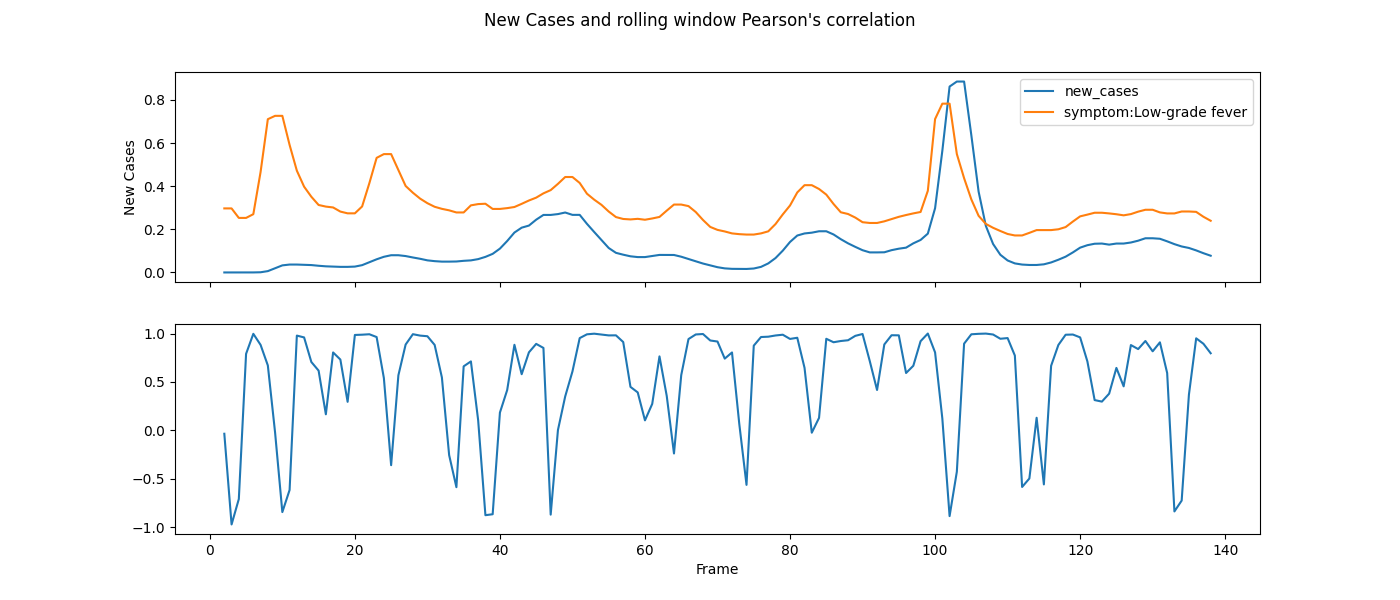

In [ ]:
display(Image("plots/new_cases_symptom:Low-grade fever_moving_windows_pcc.png"))

In [ ]:
r_window_size = 4
pccs = []
# Interpolate missing data.
#for n, symptom in enumerate(df_symptoms.Symptom):
for n, symptom in enumerate(symptoms):
    f,ax=plt.subplots(2,1,figsize=(14,6),sharex=True)
    covid_normalized = covid_data['new_deaths'] / covid_data['new_deaths'].max()
    symptom_normalized = df[symptom].interpolate()/df[symptom].interpolate().max()
    tempdf = pd.DataFrame([*zip(covid_normalized, symptom_normalized)], columns = ['new_deaths', symptom])
    tempdf.rolling(window=4,center=True).median().plot(ax=ax[0])
    ax[0].set(xlabel='Frame',ylabel='New Deaths')
    # Compute rolling window synchrony
    rolling_r = covid_normalized.rolling(window=r_window_size, center=True).corr(symptom_normalized)
    rolling_r.plot(ax=ax[1])
    pccs.append(rolling_r)
    ax[1].set(xlabel='Frame')
    plt.suptitle("New Deaths and rolling window Pearson's correlation")
    plt.savefig(f"plots/new_deaths_{symptom}_moving_windows_pcc.png")
    plt.close()
#pd.DataFrame(np.array(pccs).T, columns = list(df_symptoms.Symptom)).fillna(0).describe().loc[['mean','25%','50%','75%']]
pd.DataFrame(np.array(pccs).T, columns = list(symptoms)).fillna(0).describe().loc[['mean','25%','50%','75%']].sort_values(by=['mean'], axis=1, ascending=False)

,symptom:Panic attack,symptom:Hypoxemia,symptom:Pneumonia,symptom:Chest pain,symptom:Eye strain,symptom:Migraine,symptom:Dandruff,symptom:Anxiety,symptom:Food craving,symptom:Periorbital puffiness,...,symptom:Aphonia,symptom:Otitis media,symptom:Itch,symptom:Otitis externa,symptom:Bruise,symptom:Edema,symptom:Vomiting,symptom:Swollen feet,symptom:Otitis,symptom:Motion sickness
mean,0.284198,0.263532,0.239902,0.224361,0.216422,0.215988,0.212981,0.201453,0.194900,0.186154,...,-0.177460,-0.183647,-0.188187,-0.189666,-0.190397,-0.214932,-0.221519,-0.225082,-0.257853,-0.330872
25%,-0.151955,-0.400135,-0.359710,-0.232388,-0.225500,-0.196637,-0.405504,-0.261728,-0.226252,-0.258850,...,-0.708842,-0.772693,-0.801278,-0.785566,-0.779683,-0.729558,-0.775371,-0.726508,-0.803191,-0.888884
50%,0.436524,0.585324,0.486871,0.233806,0.389691,0.326725,0.371989,0.286849,0.249350,0.277026,...,-0.258953,-0.326109,-0.251426,-0.273008,-0.214696,-0.298377,-0.281061,-0.364958,-0.413839,-0.582918
75%,0.777983,0.904392,0.887351,0.826583,0.712894,0.706618,0.815316,0.694612,0.751874,0.717832,...,0.278613,0.341030,0.373086,0.301091,0.307956,0.165426,0.252826,0.236861,0.169688,0.181941


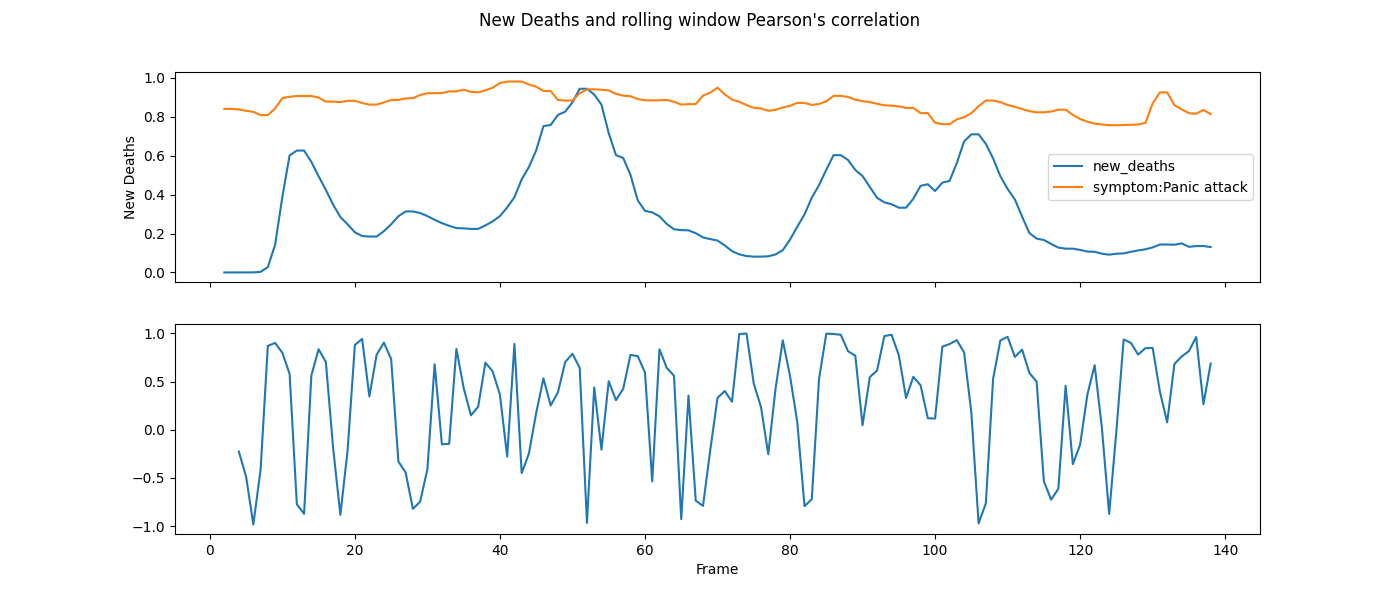

In [ ]:
display(Image("plots/new_deaths_symptom:Panic attack_moving_windows_pcc.png"))

### Time Lagged Cross Correlation

In [ ]:

def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/numpy/lib/function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


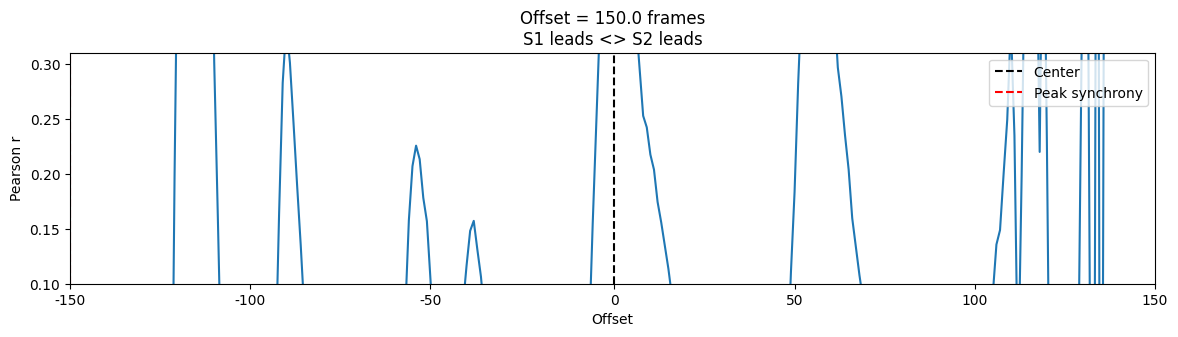

In [ ]:
d1 = covid_data['new_deaths'] / covid_data['new_deaths'].max()
d2 = df[symptom].interpolate()/df[symptom].interpolate().max()
seconds = 5
fps = 30
rs = [crosscorr(d1,d2, lag) for lag in range(-int(seconds*fps),int(seconds*fps+1))]
offset = np.floor(len(rs)/2)-np.argmax(rs)
f,ax=plt.subplots(figsize=(14,3))
ax.plot(rs)
ax.axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Offset = {offset} frames\nS1 leads <> S2 leads',ylim=[.1,.31],xlim=[0,301], xlabel='Offset',ylabel='Pearson r')
ax.set_xticks([0, 50, 100, 151, 201, 251, 301])
ax.set_xticklabels([-150, -100, -50, 0, 50, 100, 150]);
plt.legend()

<AxesSubplot: >

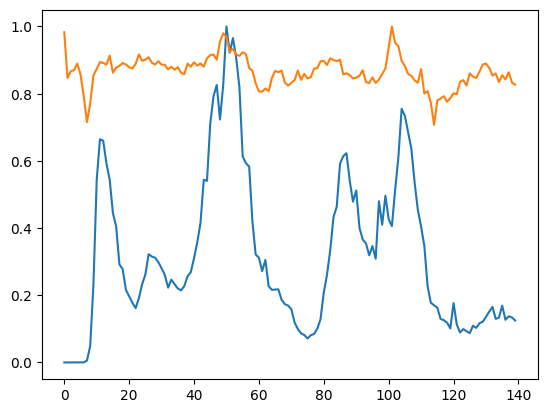

In [ ]:
d1 = covid_data['new_deaths']/ covid_data['new_deaths'].max()
d2 = df[symptom].interpolate()/df[symptom].interpolate().max()
d1.plot()
d2.plot()

### Dynamic Time Warping

In [ ]:
pccs = []
# Interpolate missing data.
#for n, symptom in enumerate(df_symptoms.Symptom):
for n, symptom in enumerate(symptoms):
    d1 = covid_data['new_cases'] / covid_data['new_cases'].max()
    d2 = df[symptom].interpolate()/df[symptom].interpolate().max()
    alignment = dtw.dtw(d1, d2, keep_internals=True)
    pccs.append(alignment.normalizedDistance)
    ## Display the warping curve, i.e. the alignment curve
    alignment.plot(type="threeway")
    plt.savefig(f"plots/{symptom}_new_cases_dtw.png")
    plt.close()
#pd.DataFrame([*zip(df_symptoms.Symptom, np.array(pccs))], columns = ['symptoms', 'normalized_distance'])
pd.DataFrame([*zip(symptoms, np.array(pccs))], columns = ['symptoms', 'normalized_distance']).sort_values(by=['normalized_distance'], axis=0, ascending=False)

,symptoms,normalized_distance
282,symptom:Oral candidiasis,0.423119
326,symptom:Pus,0.409949
360,symptom:Snoring,0.403743
218,symptom:Inflammation,0.403558
258,symptom:Mouth ulcer,0.397474
...,...,...
337,symptom:Rosacea,0.036675
369,symptom:Stroke,0.036307
135,symptom:Facial nerve paralysis,0.030339
50,symptom:Blushing,0.025059


In [ ]:
pccs = []
# Interpolate missing data.
#for n, symptom in enumerate(df_symptoms.Symptom):
for n, symptom in enumerate(symptoms):
    d1 = covid_data['new_deaths'] / covid_data['new_deaths'].max()
    d2 = df[symptom].interpolate()/df[symptom].interpolate().max()
    alignment = dtw.dtw(d1, d2, keep_internals=True)
    pccs.append(alignment.normalizedDistance)
    ## Display the warping curve, i.e. the alignment curve
    alignment.plot(type="threeway")
    plt.savefig(f"plots/{symptom}_new_deaths_dtw.png")
    plt.close()
    ## Align and plot with the Rabiner-Juang type VI-c unsmoothed recursion
    #dtw.dtw(d1, d2, keep_internals=True, 
    #    step_pattern=rabinerJuangStepPattern(6, "c"))\
    #    .plot(type="twoway",offset=-2)
#pd.DataFrame([*zip(df_symptoms.Symptom, np.array(pccs))], columns = ['symptoms', 'normalized_distance'])
pd.DataFrame([*zip(symptoms, np.array(pccs))], columns = ['symptoms', 'normalized_distance']).sort_values(by=['normalized_distance'], axis=0, ascending=False)

,symptoms,normalized_distance
282,symptom:Oral candidiasis,0.294641
138,symptom:Fatigue,0.294025
398,symptom:Urinary tract infection,0.292231
230,symptom:Kidney stone,0.286836
326,symptom:Pus,0.286777
...,...,...
41,symptom:Bell's palsy,0.058423
167,symptom:Hay fever,0.053948
304,symptom:Photodermatitis,0.044192
19,symptom:Anosmia,0.034213


### Instantaneous phase synchrony

In [ ]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

In [ ]:
lowcut  = .01
highcut = .5
fs = 30.
order = 1
for n, symptom in enumerate(df_symptoms.Symptom):
    d1 = (covid_data['new_cases'] / covid_data['new_cases'].max()).values
    d2 = (df[symptom].interpolate()/df[symptom].interpolate().max()).values
    y1 = butter_bandpass_filter(d1,lowcut=lowcut,highcut=highcut,fs=fs,order=order)
    y2 = butter_bandpass_filter(d2,lowcut=lowcut,highcut=highcut,fs=fs,order=order)
    
    al1 = np.angle(hilbert(y1),deg=False)
    al2 = np.angle(hilbert(y2),deg=False)
    phase_synchrony = 1-np.sin(np.abs(al1-al2)/2)
    N = len(al1)
    
    # Plot results
    f,ax = plt.subplots(3,1,figsize=(14,7),sharex=True)
    ax[0].plot(y1,color='r',label='y1')
    ax[0].plot(y2,color='b',label='y2')
    ax[0].legend(bbox_to_anchor=(0., 1.02, 1., .102),ncol=2)
    ax[0].set(xlim=[0,N], title='Filtered Timeseries Data')
    ax[1].plot(al1,color='r')
    ax[1].plot(al2,color='b')
    ax[1].set(ylabel='Angle',title='Angle at each Timepoint',xlim=[0,N])
    phase_synchrony = 1-np.sin(np.abs(al1-al2)/2)
    ax[2].plot(phase_synchrony)
    ax[2].set(ylim=[0,1.1],xlim=[0,N],title='Instantaneous Phase Synchrony',xlabel='Time',ylabel='Phase Synchrony')
    plt.tight_layout()
    plt.savefig(f"plots/{symptom}_new_cases_ips.png")
    plt.close()

In [ ]:
lowcut  = .01
highcut = .5
fs = 30.
order = 1
for n, symptom in enumerate(df_symptoms.Symptom):
    d1 = (covid_data['new_deaths'] / covid_data['new_deaths'].max()).values
    d2 = (df[symptom].interpolate()/df[symptom].interpolate().max()).values
    y1 = butter_bandpass_filter(d1,lowcut=lowcut,highcut=highcut,fs=fs,order=order)
    y2 = butter_bandpass_filter(d2,lowcut=lowcut,highcut=highcut,fs=fs,order=order)
    
    al1 = np.angle(hilbert(y1),deg=False)
    al2 = np.angle(hilbert(y2),deg=False)
    phase_synchrony = 1-np.sin(np.abs(al1-al2)/2)
    N = len(al1)
    
    # Plot results
    f,ax = plt.subplots(3,1,figsize=(14,7),sharex=True)
    ax[0].plot(y1,color='r',label='y1')
    ax[0].plot(y2,color='b',label='y2')
    ax[0].legend(bbox_to_anchor=(0., 1.02, 1., .102),ncol=2)
    ax[0].set(xlim=[0,N], title='Filtered Timeseries Data')
    ax[1].plot(al1,color='r')
    ax[1].plot(al2,color='b')
    ax[1].set(ylabel='Angle',title='Angle at each Timepoint',xlim=[0,N])
    phase_synchrony = 1-np.sin(np.abs(al1-al2)/2)
    ax[2].plot(phase_synchrony)
    ax[2].set(ylim=[0,1.1],xlim=[0,N],title='Instantaneous Phase Synchrony',xlabel='Time',ylabel='Phase Synchrony')
    plt.tight_layout()
    plt.savefig(f"plots/{symptom}_new_deaths_ips.png")
    plt.close()